In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from pyspark.sql import SparkSession, dataframe
from pyspark.sql.types import StructType, StructField, DoubleType
import xgboost as xgb
import time
import glob
import json
from matplotlib import rc

rc('text', usetex=True)
plt.rcParams['text.latex.preamble'] = []
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Times New Roman'
plt.rcParams['font.weight'] = 'light'

df_dict = {}

2022-11-17 21:59:10.591947: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-17 21:59:12.841661: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /software/gcc/8.2/lib64:/software/openmpi-intel/3.1.6/lib:/opt/intel/2019/compilers_and_libraries/linux/compiler/lib/intel64_lin/:/beegfs/desy/user/apaul/HEPfit/BAT_parallel/lib:/home/apaul/opt/local/lib/root:/home/apaul/opt/local/lib:/home/apaul/opt/local/lib64:
2022-11-17 21:59:12.841701: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on yo

In [53]:
data = {}
# Spark session and configuration
spark = (SparkSession.builder.master("local[48]")
         .config('spark.executor.instances', 16)
         .config('spark.executor.cores', 16)
         .config('spark.executor.memory', '10g')
         .config('spark.driver.memory', '15g')
         .config('spark.memory.offHeap.enabled', True)
         .config('spark.memory.offHeap.size', '20g')
         .config('spark.dirver.maxResultSize', '20g')
         .config('spark.debug.maxToStringFields', 100)
         .appName("amp.hell").getOrCreate())

# Enable Arrow-based columnar data 
spark.conf.set("spark.sql.execution.arrow.pyspark.enabled", "true")
spark.conf.set(
    "spark.sql.execution.arrow.pyspark.fallback.enabled", "true"
)

def loadData(dim=8, spark=spark):
    # read the data into a spark frame
    start = time.time()
    path = '../data/'
    header = ['x'+str(i+1) for i in range(dim)] + ['yN', 'y_2'] 
    schema = StructType([StructField(header[i], DoubleType(), True) for i in range(dim+2)])
    df = spark.read.options(delimiter=',').schema(schema).format("csv").load(path+str(dim)+'D'+'/test/*.csv.*', header='true')

    print('INFO: '+str(dim)+'D data loaded into Spark session in {:.3f} seconds'.format(time.time() - start))

    # transfer the data to a pandas dataframe
    start = time.time()
    df_p = df.limit(1000000).toPandas() 
    print('INFO: '+str(dim)+'D data loaded into pandas dataframe in {:.3f} seconds'.format(time.time() - start))
    return df_p

def testModel(path: str, df_dict=df_dict, column='yN', data=data):
#     df = df_in.copy(deep=True)
    if any(x in path for x in ['dnn', 'skip']):
        # load the model
        regressor = tf.keras.models.load_model(glob.glob(path+'/dnn-*.tfm.hdf5')[0])
        # load the best weights
        regressor.load_weights(glob.glob(path+'/checkpoint-*.hdf5')[0])
        #load the config file
        with open(glob.glob(path+'/config*.json')[0]) as f:
            config = json.load(f)
        key = str(config['input_shape']) +'-'+ str(config['model_type']) +'-'+ str(config['depth'])
        
    if 'bdt' in path:
        # load the model
        regressor = xgb.XGBRegressor()
        regressor.load_model(glob.glob(path+'/bdt*.ubj')[0])
        #load the config file
        with open(glob.glob(path+'/config*.json')[0]) as f:
            config = json.load(f)
        key = str(config['input_shape']) +'-bdt-'+ str(config['max_depth'])
            
    df = df_dict[str(config['input_shape'])].copy(deep=True)
    
    if config['scaled'] == 'normal':
        df['y_pred'] = regressor.predict(df[['x'+str(i+1) for i in range(config['input_shape'])]]) * config['sigma'] + config['mu']
    elif config['scaled'] == 'log':
        df['y_pred'] = np.exp(regressor.predict(df[['x'+str(i+1) for i in range(config['input_shape'])]]) * config['sigma'] + config['mu'])
    else:
        df['y_pred'] = regressor.predict(df[['x'+str(i+1) for i in range(config['input_shape'])]])
        
    df['relative_error'] = df['y_pred']/df[column] - 1
    df['relative_percentage_error'] = df['relative_error'] * 100
    
    data[key] = {}
    data[key]['config'] = config
    data[key]['df'] = df
    
    
def labeler(index: str, t=0, data=data) -> str:
    if t == 0:
        return '{}-{} ({:,})'.format(data[index]['config']['depth'], data[index]['config']['width'], data[index]['config']['trainable_parameters'])
    else:
        return 'max-depth: {}'.format(str(data[index]['config']['max_depth']))
    
def getErrorTail(bound: float, data=data):
    errorTails = {}
    for key in data.keys():
        print(key)
        errorTails[key] = {}
        errorTails[key]['type'] = labeler(str(key), data=data) if 'width' in data[key]['config'].keys() else labeler(str(key), 1, data=data)
        errorTails[key]['error < '+str(bound)+'%'] = np.round((data[key]['df'][abs(data[key]['df']['relative_percentage_error']) < bound].shape[0]/data[key]['df'].shape[0])*100, 2)
        errorTails[key]['error < '+str(bound/10)+'%'] = np.round((data[key]['df'][abs(data[key]['df']['relative_percentage_error']) < bound/10].shape[0]/data[key]['df'].shape[0])*100, 2)
        errorTails[key]['$\mu_{error}$ (%)'] = np.round(data[key]['df']['relative_percentage_error'].mean(), 4)
        errorTails[key]['$\sigma_{error}$ (%)'] = np.round(data[key]['df']['relative_percentage_error'].std(), 2)
    return errorTails

In [25]:
df_dict['2'] = loadData(2)
df_dict['4'] = loadData(4)
df_dict['8'] = loadData(8)
files = {}
for dim in ['2', '4', '8']:
    for model in ['dnn', 'bdt']:
        files[model+dim] = sorted(glob.glob('../src/'+model+'/RUNS-'+dim+'D/*'))

INFO: 2D data loaded into Spark session in 0.355 seconds
INFO: 2D data loaded into pandas dataframe in 5.032 seconds
INFO: 4D data loaded into Spark session in 0.305 seconds


INFO: 4D data loaded into pandas dataframe in 5.840 seconds
INFO: 8D data loaded into Spark session in 0.255 seconds


INFO: 8D data loaded into pandas dataframe in 9.045 seconds


In [27]:
data = {}

for key in files.keys():
    for file in files[key]:
        testModel(file, df_dict, data=data)

31250/31250 [==============================] - 21s 653us/step


In [28]:
base = {}
baseline = sorted(glob.glob('../src/dnn/RUNS-baseline/*'))
for file in baseline:
    testModel(file, df_dict, column='y_2', data=base)

31250/31250 [==============================] - 27s 860us/step


In [36]:
# BDT
# 2D
# data['2-bdt-10'] = {}
# data['2-bdt-10']['df'] = pd.read_csv('../../machine-casting/results/errors/2D/BDT-10.csv')
# with open('../../machine-casting/scripts/BDT/RUNS-2D/BDT-XGB-2D-yRT-54ebe0ae-normal-10-0.01-99.999393/config-54ebe0ae.json') as f:
#     config = json.load(f)
# data['2-bdt-10']['config'] = config

# data['2-bdt-20'] = {}
# data['2-bdt-20']['df'] = pd.read_csv('../../machine-casting/results/errors/2D/BDT-20.csv')
# with open('../../machine-casting/scripts/BDT/RUNS-2D/BDT-XGB-2D-yRT-91b70f36-normal-20-0.01-99.999622/config-91b70f36.json') as f:
#     config = json.load(f)
# data['2-bdt-20']['config'] = config

# data['2-bdt-50'] = {}
# data['2-bdt-50']['df'] = pd.read_csv('../../machine-casting/results/errors/2D/BDT-50.csv')
# with open('../../machine-casting/scripts/BDT/RUNS-2D/BDT-XGB-2D-yRT-c6a999dd-normal-50-0.01-99.999628/config-c6a999dd.json') as f:
#     config = json.load(f)
# data['2-bdt-50']['config'] = config

base['2-bdt-50'] = {}
base['2-bdt-50']['df'] = pd.read_csv('../../machine-casting/results/errors/2D/BDT-baseline.csv')
with open('../../machine-casting/scripts/BDT/RUNS-2D/BDT-XGB-BASE-2D-y_1-ec451eaf-log-50-0.1-99.999935/config-ec451eaf.json') as f:
    config = json.load(f)
base['2-bdt-50']['config'] = config

# 4D
# data['4-bdt-10'] = {}
# data['4-bdt-10']['df'] = pd.read_csv('../../machine-casting/results/errors/4D/BDT-10.csv')
# with open('../../machine-casting/scripts/BDT/RUNS-4D/BDT-XGB-4D-yRT-3cb4255e-normal-10-0.01-99.986033/config-3cb4255e.json') as f:
#     config = json.load(f)
# data['4-bdt-10']['config'] = config

# data['4-bdt-20'] = {}
# data['4-bdt-20']['df'] = pd.read_csv('../../machine-casting/results/errors/4D/BDT-20.csv')
# with open('../../machine-casting/scripts/BDT/RUNS-4D/BDT-XGB-4D-yRT-33d33c51-normal-20-0.01-99.986040/config-33d33c51.json') as f:
#     config = json.load(f)
# data['4-bdt-20']['config'] = config

# data['4-bdt-50'] = {}
# data['4-bdt-50']['df'] = pd.read_csv('../../machine-casting/results/errors/4D/BDT-50.csv')
# with open('../../machine-casting/scripts/BDT/RUNS-4D/BDT-XGB-4D-yRT-6c753896-normal-50-0.01-99.985983/config-6c753896.json') as f:
#     config = json.load(f)
# data['4-bdt-50']['config'] = config

base['4-bdt-50'] = {}
base['4-bdt-50']['df'] = pd.read_csv('../../machine-casting/results/errors/4D/BDT-baseline.csv')
with open('../../machine-casting/scripts/BDT/RUNS-4D/BDT-XGB-BASE-4D-y_1-8dc74820-log-50-0.1-99.996645/config-8dc74820.json') as f:
    config = json.load(f)
base['4-bdt-50']['config'] = config

# 8D
# data['8-bdt-10'] = {}
# data['8-bdt-10']['df'] = pd.read_csv('../../machine-casting/results/errors/8D/BDT-10.csv')
# with open('../../machine-casting/scripts/BDT/RUNS-8D/BDT-XGB-8D-y3_y1-f7a4317a-normal-10-0.01-99.842687/config-f7a4317a.json') as f:
#     config = json.load(f)
# data['8-bdt-10']['config'] = config

# data['8-bdt-20'] = {}
# data['8-bdt-20']['df'] = pd.read_csv('../../machine-casting/results/errors/8D/BDT-20.csv')
# with open('../../machine-casting/scripts/BDT/RUNS-8D/BDT-XGB-8D-y3_y1-10eb934b-normal-20-0.01-99.783738/config-10eb934b.json') as f:
#     config = json.load(f)
# data['8-bdt-20']['config'] = config

# data['8-bdt-50'] = {}
# data['8-bdt-50']['df'] = pd.read_csv('../../machine-casting/results/errors/8D/BDT-50.csv')
# with open('../../machine-casting/scripts/BDT/RUNS-8D/BDT-XGB-8D-y3_y1-69347ac5-normal-50-0.01-99.729561/config-69347ac5.json') as f:
#     config = json.load(f)
# data['8-bdt-50']['config'] = config

base['8-bdt-50'] = {}
base['8-bdt-50']['df'] = pd.read_csv('../../machine-casting/results/errors/8D/BDT-baseline.csv')
with open('../../machine-casting/scripts/BDT/RUNS-8D/BDT-XGB-BASE-8D-y3-7790abd1-normal-50-0.1-92.356075/config-7790abd1.json') as f:
    config = json.load(f)
base['8-bdt-50']['config'] = config

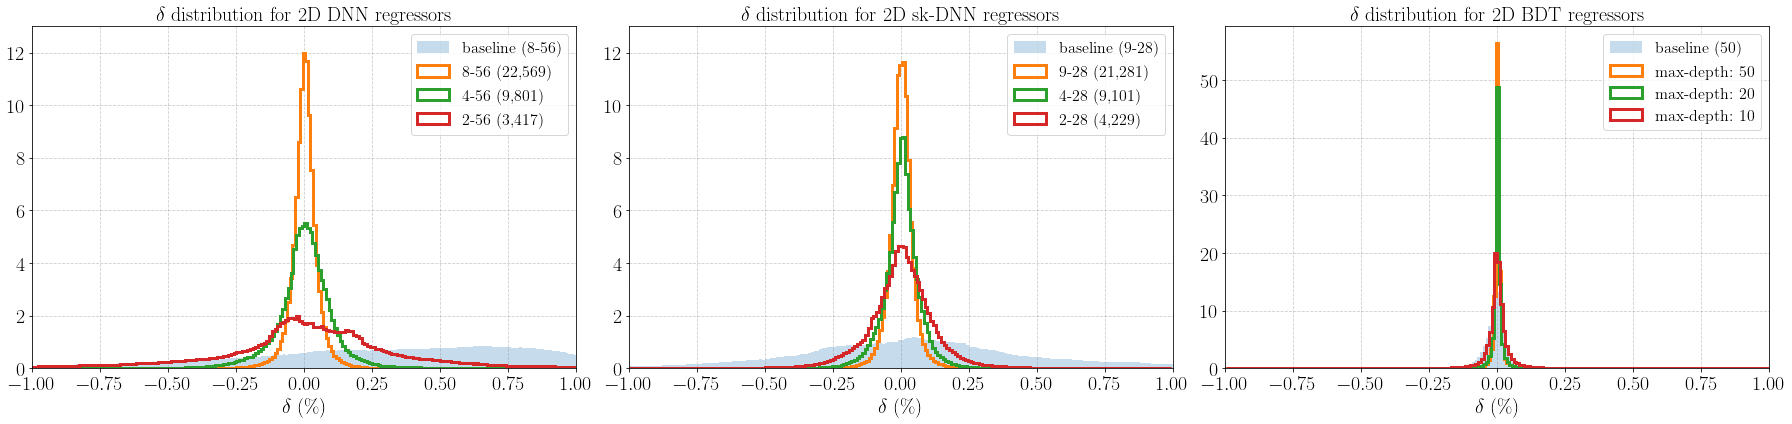

In [42]:
plt.figure(figsize=(25,6))
lim = 1
bins = 200
linewidth = 3
plt.subplot(1, 3, 1)
# plt.hist(data['2-dnn-12']['df'][abs(data['2-dnn-12']['df']['relative_percentage_error']) < lim]['relative_percentage_error'], bins=bins, histtype='step', linewidth=linewidth, density=True, label=labeler('2-dnn-12'))
plt.hist(base['2-dnn-8']['df'][abs(base['2-dnn-8']['df']['relative_percentage_error']) < lim]['relative_percentage_error'], bins=bins, alpha=0.25, linewidth=linewidth, density=True, label='baseline (8-56)')
plt.hist(data['2-dnn-8']['df'][abs(data['2-dnn-8']['df']['relative_percentage_error']) < lim]['relative_percentage_error'], bins=bins, histtype='step', linewidth=linewidth, density=True, label=labeler('2-dnn-8'))
plt.hist(data['2-dnn-4']['df'][abs(data['2-dnn-4']['df']['relative_percentage_error']) < lim]['relative_percentage_error'], bins=bins, histtype='step', linewidth=linewidth, density=True, label=labeler('2-dnn-4'))
plt.hist(data['2-dnn-2']['df'][abs(data['2-dnn-2']['df']['relative_percentage_error']) < lim]['relative_percentage_error'], bins=bins, histtype='step', linewidth=linewidth, density=True, label=labeler('2-dnn-2'))
plt.xlabel(r'$\delta$ (\%)', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlim((-lim, lim))
plt.ylim((0, 13))
plt.grid(linestyle='dashed', alpha=0.4, color='#808080')
plt.legend(fontsize=16)
plt.title(r'$\delta$ distribution for 2D DNN regressors', fontsize=20)

plt.subplot(1, 3, 2)
# plt.hist(data['2-skip-14']['df'][abs(data['2-skip-14']['df']['relative_percentage_error']) < lim]['relative_percentage_error'], bins=bins, histtype='step', linewidth=linewidth, density=True, label=labeler('2-skip-14'))
plt.hist(base['2-skip-9']['df'][abs(base['2-skip-9']['df']['relative_percentage_error']) < lim]['relative_percentage_error'], bins=bins, alpha=0.25, linewidth=linewidth, density=True, label='baseline (9-28)')
plt.hist(data['2-skip-9']['df'][abs(data['2-skip-9']['df']['relative_percentage_error']) < lim]['relative_percentage_error'], bins=bins, histtype='step', linewidth=linewidth, density=True, label=labeler('2-skip-9'))
plt.hist(data['2-skip-4']['df'][abs(data['2-skip-4']['df']['relative_percentage_error']) < lim]['relative_percentage_error'], bins=bins, histtype='step', linewidth=linewidth, density=True, label=labeler('2-skip-4'))
plt.hist(data['2-skip-2']['df'][abs(data['2-skip-2']['df']['relative_percentage_error']) < lim]['relative_percentage_error'], bins=bins, histtype='step', linewidth=linewidth, density=True, label=labeler('2-skip-2'))
plt.xlabel(r'$\delta$ (\%)', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlim((-lim, lim))
plt.ylim((0, 13))
plt.grid(linestyle='dashed', alpha=0.4, color='#808080')
plt.legend(fontsize=16)
plt.title(r'$\delta$ distribution for 2D sk-DNN regressors', fontsize=20)

plt.subplot(1, 3, 3)
lim = 1
plt.hist(base['2-bdt-50']['df'][abs(base['2-bdt-50']['df']['relative_percentage_error']) < lim]['relative_percentage_error'], bins=bins, alpha=0.25, linewidth=linewidth, density=True, label='baseline (50)')
plt.hist(data['2-bdt-50']['df'][abs(data['2-bdt-50']['df']['relative_percentage_error']) < lim]['relative_percentage_error'], bins=bins, histtype='step', linewidth=linewidth, density=True, label=labeler('2-bdt-50', 1))
plt.hist(data['2-bdt-20']['df'][abs(data['2-bdt-20']['df']['relative_percentage_error']) < lim]['relative_percentage_error'], bins=bins, histtype='step', linewidth=linewidth, density=True, label=labeler('2-bdt-20', 1))
plt.hist(data['2-bdt-10']['df'][abs(data['2-bdt-10']['df']['relative_percentage_error']) < lim]['relative_percentage_error'], bins=bins, histtype='step', linewidth=linewidth, density=True, label=labeler('2-bdt-10', 1))
plt.xlabel(r'$\delta$ (\%)', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlim((-lim, lim))
plt.grid(linestyle='dashed', alpha=0.4, color='#808080')
plt.legend(fontsize=16)
plt.title(r'$\delta$ distribution for 2D BDT regressors', fontsize=20)
plt.tight_layout()
plt.savefig('../plots/errors-2D.pdf', dpi=300)
plt.show()

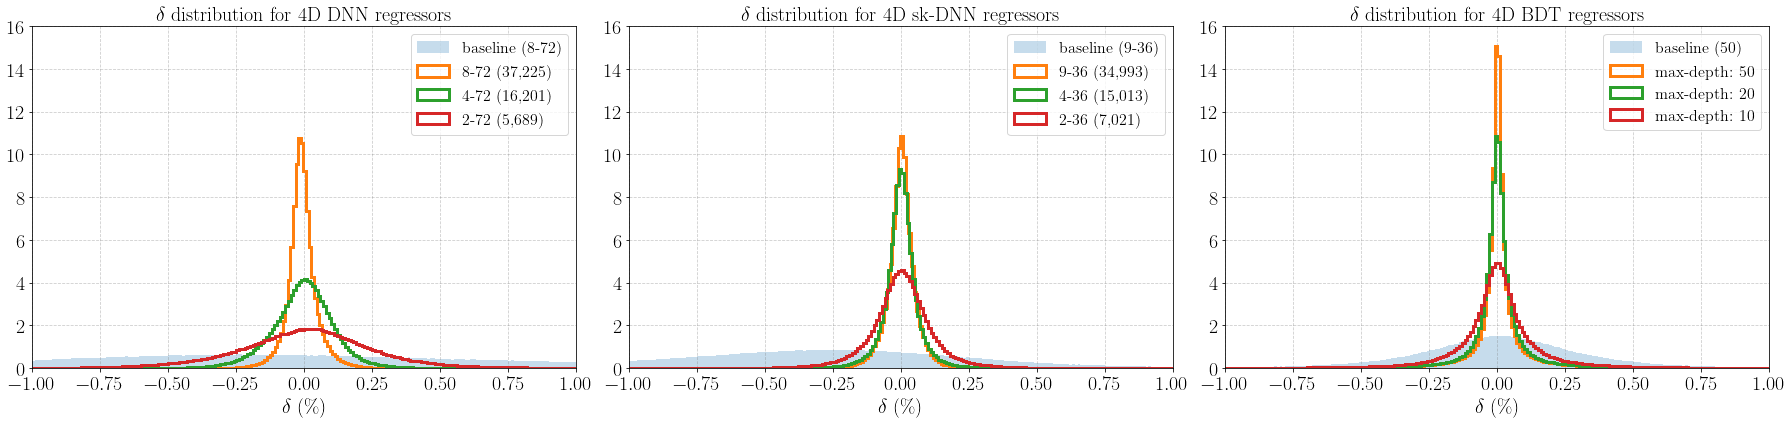

In [41]:
plt.figure(figsize=(25,6))
lim = 1
bins = 200
linewidth = 3
plt.subplot(1, 3, 1)
# plt.hist(data['4-dnn-12']['df'][abs(data['4-dnn-12']['df']['relative_percentage_error']) < lim]['relative_percentage_error'], bins=bins, histtype='step', linewidth=linewidth, density=True, label=labeler('4-dnn-12'))
plt.hist(base['4-dnn-8']['df'][abs(base['4-dnn-8']['df']['relative_percentage_error']) < lim]['relative_percentage_error'], bins=bins, alpha=0.25, linewidth=linewidth, density=True, label='baseline (8-72)')
plt.hist(data['4-dnn-8']['df'][abs(data['4-dnn-8']['df']['relative_percentage_error']) < lim]['relative_percentage_error'], bins=bins, histtype='step', linewidth=linewidth, density=True, label=labeler('4-dnn-8'))
plt.hist(data['4-dnn-4']['df'][abs(data['4-dnn-4']['df']['relative_percentage_error']) < lim]['relative_percentage_error'], bins=bins, histtype='step', linewidth=linewidth, density=True, label=labeler('4-dnn-4'))
plt.hist(data['4-dnn-2']['df'][abs(data['4-dnn-2']['df']['relative_percentage_error']) < lim]['relative_percentage_error'], bins=bins, histtype='step', linewidth=linewidth, density=True, label=labeler('4-dnn-2'))
plt.xlabel(r'$\delta$ (\%)', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlim((-lim, lim))
plt.ylim((0, 16))
plt.grid(linestyle='dashed', alpha=0.4, color='#808080')
plt.legend(fontsize=16)
plt.title(r'$\delta$ distribution for 4D DNN regressors', fontsize=20)

plt.subplot(1, 3, 2)
# plt.hist(data['4-skip-14']['df'][abs(data['4-skip-14']['df']['relative_percentage_error']) < lim]['relative_percentage_error'], bins=bins, histtype='step', linewidth=linewidth, density=True, label=labeler('4-skip-14'))
plt.hist(base['4-skip-9']['df'][abs(base['4-skip-9']['df']['relative_percentage_error']) < lim]['relative_percentage_error'], bins=bins, alpha=0.25, linewidth=linewidth, density=True, label='baseline (9-36)')
plt.hist(data['4-skip-9']['df'][abs(data['4-skip-9']['df']['relative_percentage_error']) < lim]['relative_percentage_error'], bins=bins, histtype='step', linewidth=linewidth, density=True, label=labeler('4-skip-9'))
plt.hist(data['4-skip-4']['df'][abs(data['4-skip-4']['df']['relative_percentage_error']) < lim]['relative_percentage_error'], bins=bins, histtype='step', linewidth=linewidth, density=True, label=labeler('4-skip-4'))
plt.hist(data['4-skip-2']['df'][abs(data['4-skip-2']['df']['relative_percentage_error']) < lim]['relative_percentage_error'], bins=bins, histtype='step', linewidth=linewidth, density=True, label=labeler('4-skip-2'))
plt.xlabel(r'$\delta$ (\%)', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlim((-lim, lim))
plt.ylim((0, 16))
plt.grid(linestyle='dashed', alpha=0.4, color='#808080')
plt.legend(fontsize=16)
plt.title(r'$\delta$ distribution for 4D sk-DNN regressors', fontsize=20)

plt.subplot(1, 3, 3)
lim = 1
plt.hist(base['4-bdt-50']['df'][abs(base['4-bdt-50']['df']['relative_percentage_error']) < lim]['relative_percentage_error'], bins=bins, alpha=0.25, linewidth=linewidth, density=True, label='baseline (50)')
plt.hist(data['4-bdt-50']['df'][abs(data['4-bdt-50']['df']['relative_percentage_error']) < lim]['relative_percentage_error'], bins=bins, histtype='step', linewidth=linewidth, density=True, label=labeler('4-bdt-50', 1))
plt.hist(data['4-bdt-20']['df'][abs(data['4-bdt-20']['df']['relative_percentage_error']) < lim]['relative_percentage_error'], bins=bins, histtype='step', linewidth=linewidth, density=True, label=labeler('4-bdt-20', 1))
plt.hist(data['4-bdt-10']['df'][abs(data['4-bdt-10']['df']['relative_percentage_error']) < lim]['relative_percentage_error'], bins=bins, histtype='step', linewidth=linewidth, density=True, label=labeler('4-bdt-10', 1))
plt.xlabel(r'$\delta$ (\%)', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlim((-lim, lim))
plt.ylim((0, 16))
plt.grid(linestyle='dashed', alpha=0.4, color='#808080')
plt.legend(fontsize=16)
plt.title(r'$\delta$ distribution for 4D BDT regressors', fontsize=20)
plt.tight_layout()
plt.savefig('../plots/errors-4D.pdf', dpi=300)
plt.show()

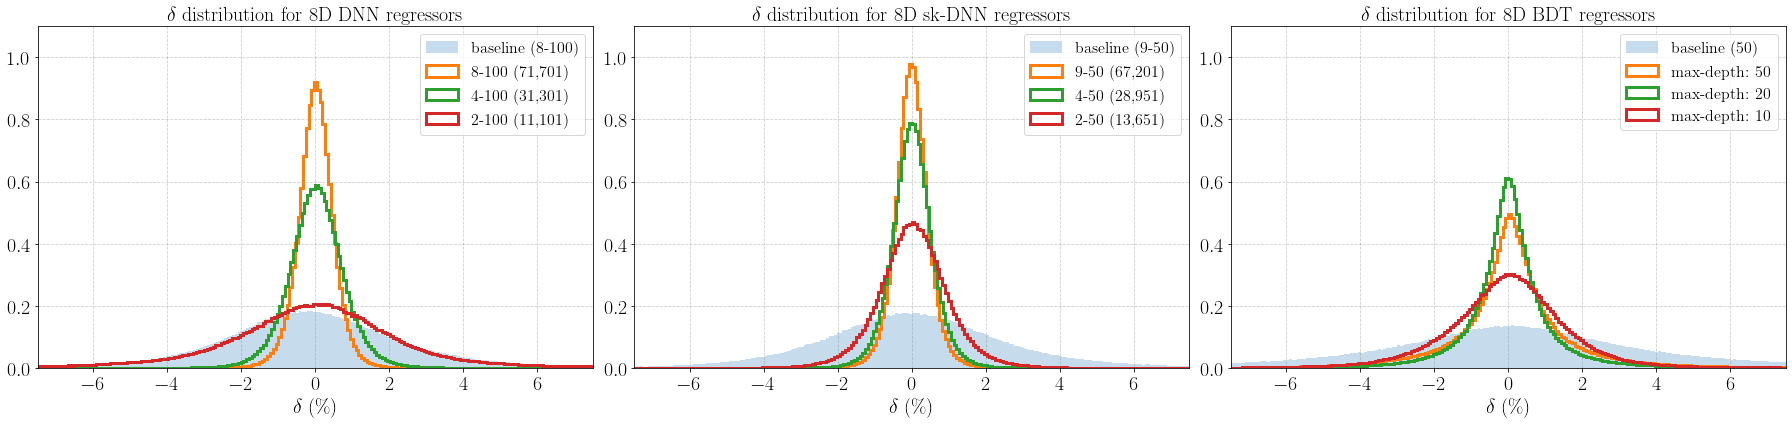

In [43]:
plt.figure(figsize=(25,6))
lim = 7.5
bins = 200
linewidth = 3
plt.subplot(1, 3, 1)
# plt.hist(data['8-dnn-12']['df'][abs(data['8-dnn-12']['df']['relative_percentage_error']) < lim]['relative_percentage_error'], bins=bins, histtype='step', linewidth=linewidth, density=True, label=labeler('8-dnn-12'))
plt.hist(base['8-dnn-8']['df'][abs(base['8-dnn-8']['df']['relative_percentage_error']) < lim]['relative_percentage_error'], bins=bins, alpha=0.25, linewidth=linewidth, density=True, label='baseline (8-100)')
plt.hist(data['8-dnn-8']['df'][abs(data['8-dnn-8']['df']['relative_percentage_error']) < lim]['relative_percentage_error'], bins=bins, histtype='step', linewidth=linewidth, density=True, label=labeler('8-dnn-8'))
plt.hist(data['8-dnn-4']['df'][abs(data['8-dnn-4']['df']['relative_percentage_error']) < lim]['relative_percentage_error'], bins=bins, histtype='step', linewidth=linewidth, density=True, label=labeler('8-dnn-4'))
plt.hist(data['8-dnn-2']['df'][abs(data['8-dnn-2']['df']['relative_percentage_error']) < lim]['relative_percentage_error'], bins=bins, histtype='step', linewidth=linewidth, density=True, label=labeler('8-dnn-2'))
plt.xlabel(r'$\delta$ (\%)', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlim((-lim, lim))
plt.ylim((0, 1.1))
plt.grid(linestyle='dashed', alpha=0.4, color='#808080')
plt.legend(fontsize=16)
plt.title(r'$\delta$ distribution for 8D DNN regressors', fontsize=20)

plt.subplot(1, 3, 2)
# plt.hist(data['8-skip-14']['df'][abs(data['8-skip-14']['df']['relative_percentage_error']) < lim]['relative_percentage_error'], bins=bins, histtype='step', linewidth=linewidth, density=True, label=labeler('8-skip-14'))
plt.hist(base['8-skip-9']['df'][abs(base['8-skip-9']['df']['relative_percentage_error']) < lim]['relative_percentage_error'], bins=bins, alpha=0.25, linewidth=linewidth, density=True, label='baseline (9-50)')
plt.hist(data['8-skip-9']['df'][abs(data['8-skip-9']['df']['relative_percentage_error']) < lim]['relative_percentage_error'], bins=bins, histtype='step', linewidth=linewidth, density=True, label=labeler('8-skip-9'))
plt.hist(data['8-skip-4']['df'][abs(data['8-skip-4']['df']['relative_percentage_error']) < lim]['relative_percentage_error'], bins=bins, histtype='step', linewidth=linewidth, density=True, label=labeler('8-skip-4'))
plt.hist(data['8-skip-2']['df'][abs(data['8-skip-2']['df']['relative_percentage_error']) < lim]['relative_percentage_error'], bins=bins, histtype='step', linewidth=linewidth, density=True, label=labeler('8-skip-2'))
plt.xlabel(r'$\delta$ (\%)', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlim((-lim, lim))
plt.ylim((0, 1.1))
plt.grid(linestyle='dashed', alpha=0.4, color='#808080')
plt.legend(fontsize=16)
plt.title(r'$\delta$ distribution for 8D sk-DNN regressors', fontsize=20)

plt.subplot(1, 3, 3)
lim = 7.5
plt.hist(base['8-bdt-50']['df'][abs(base['8-bdt-50']['df']['relative_percentage_error']) < lim]['relative_percentage_error'], bins=bins, alpha=0.25, linewidth=linewidth, density=True, label='baseline (50)')
plt.hist(data['8-bdt-50']['df'][abs(data['8-bdt-50']['df']['relative_percentage_error']) < lim]['relative_percentage_error'], bins=bins, histtype='step', linewidth=linewidth, density=True, label=labeler('8-bdt-50', 1))
plt.hist(data['8-bdt-20']['df'][abs(data['8-bdt-20']['df']['relative_percentage_error']) < lim]['relative_percentage_error'], bins=bins, histtype='step', linewidth=linewidth, density=True, label=labeler('8-bdt-20', 1))
plt.hist(data['8-bdt-10']['df'][abs(data['8-bdt-10']['df']['relative_percentage_error']) < lim]['relative_percentage_error'], bins=bins, histtype='step', linewidth=linewidth, density=True, label=labeler('8-bdt-10', 1))
plt.xlabel(r'$\delta$ (\%)', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlim((-lim, lim))
plt.ylim((0, 1.1))
plt.grid(linestyle='dashed', alpha=0.4, color='#808080')
plt.legend(fontsize=16)
plt.title(r'$\delta$ distribution for 8D BDT regressors', fontsize=20)
plt.tight_layout()
plt.savefig('../plots/errors-8D.pdf', dpi=300)
plt.show()

In [44]:
print(pd.DataFrame.from_dict(getErrorTail(1)).T.to_latex())

\begin{tabular}{llllll}
\toprule
{} &              type & error < 1\% & error < 0.1\% & \$\textbackslash mu\_\{error\}\$ (\%) & \$\textbackslash sigma\_\{error\}\$ (\%) \\
\midrule
2-dnn-12  &    12-56 (35,337) &      100.0 &        96.33 &            0.0004 &                 0.05 \\
2-dnn-2   &      2-56 (3,417) &      95.54 &        32.43 &            0.0114 &                 0.52 \\
2-dnn-8   &     8-56 (22,569) &      99.99 &        94.43 &              -0.0 &                 0.06 \\
2-dnn-4   &      4-56 (9,801) &      99.95 &        75.58 &           -0.0005 &                 0.13 \\
2-skip-9  &     9-28 (21,281) &      100.0 &        95.72 &           -0.0005 &                 0.05 \\
2-skip-2  &      2-28 (4,229) &      99.92 &        67.71 &            0.0001 &                 0.14 \\
2-skip-14 &    14-28 (33,461) &      100.0 &        97.75 &               0.0 &                 0.04 \\
2-skip-4  &      4-28 (9,101) &      99.99 &        87.95 &            0.0012 &            

In [54]:
print(pd.DataFrame.from_dict(getErrorTail(1, data=base)).T.to_latex())

2-dnn-8
4-dnn-8
8-dnn-8
2-skip-9
4-skip-9
8-skip-9
2-bdt-50
4-bdt-50
8-bdt-50
\begin{tabular}{llllll}
\toprule
{} &            type & error < 1\% & error < 0.1\% & \$\textbackslash mu\_\{error\}\$ (\%) & \$\textbackslash sigma\_\{error\}\$ (\%) \\
\midrule
2-dnn-8  &   8-56 (22,569) &      73.01 &         8.61 &            0.7525 &                 2.65 \\
4-dnn-8  &   8-72 (37,225) &      71.98 &         8.69 &           -0.0177 &                 1.44 \\
8-dnn-8  &  8-100 (71,701) &      33.59 &         3.54 &            0.0109 &                 6.36 \\
2-skip-9 &   9-28 (21,281) &      84.78 &        17.89 &             0.214 &                 1.99 \\
4-skip-9 &   9-36 (34,993) &      83.34 &         12.3 &           -0.3251 &                 1.14 \\
8-skip-9 &   9-50 (67,201) &      32.73 &         3.42 &            0.1506 &                 6.32 \\
2-bdt-50 &   max-depth: 50 &      99.91 &        94.04 &           -0.0045 &                  0.1 \\
4-bdt-50 &   max-depth: 50 &      95

In [50]:
base.keys()

dict_keys(['2-dnn-8', '4-dnn-8', '8-dnn-8', '2-skip-9', '4-skip-9', '8-skip-9', '2-bdt-50', '4-bdt-50', '8-bdt-50'])

In [12]:
data['2-dnn-2']['df'].to_csv('../results/errors/2D/DNN_2_56.csv', index=False)
data['2-dnn-4']['df'].to_csv('../results/errors/2D/DNN_4_56.csv', index=False)
data['2-dnn-8']['df'].to_csv('../results/errors/2D/DNN_8_56.csv', index=False)

data['4-dnn-2']['df'].to_csv('../results/errors/4D/DNN_2_72.csv', index=False)
data['4-dnn-4']['df'].to_csv('../results/errors/4D/DNN_4_72.csv', index=False)
data['4-dnn-8']['df'].to_csv('../results/errors/4D/DNN_8_72.csv', index=False)

data['8-dnn-2']['df'].to_csv('../results/errors/8D/DNN_2_100.csv', index=False)
data['8-dnn-4']['df'].to_csv('../results/errors/8D/DNN_4_100.csv', index=False)
data['8-dnn-8']['df'].to_csv('../results/errors/8D/DNN_8_100.csv', index=False)

In [13]:
data['2-skip-2']['df'].to_csv('../results/errors/2D/sk-DNN_2_28.csv', index=False)
data['2-skip-4']['df'].to_csv('../results/errors/2D/sk-DNN_4_28.csv', index=False)
data['2-skip-9']['df'].to_csv('../results/errors/2D/sk-DNN_9_28.csv', index=False)

data['4-skip-2']['df'].to_csv('../results/errors/4D/sk-DNN_2_36.csv', index=False)
data['4-skip-4']['df'].to_csv('../results/errors/4D/sk-DNN_4_36.csv', index=False)
data['4-skip-9']['df'].to_csv('../results/errors/4D/sk-DNN_9_36.csv', index=False)

data['8-skip-2']['df'].to_csv('../results/errors/8D/sk-DNN_2_50.csv', index=False)
data['8-skip-4']['df'].to_csv('../results/errors/8D/sk-DNN_4_50.csv', index=False)
data['8-skip-9']['df'].to_csv('../results/errors/8D/sk-DNN_9_50.csv', index=False)

In [38]:
data['8-bdt-10']['df'].to_csv('../results/errors/8D/BDT_10.csv', index=False)
data['8-bdt-20']['df'].to_csv('../results/errors/8D/BDT_20.csv', index=False)
data['8-bdt-50']['df'].to_csv('../results/errors/8D/BDT_50.csv', index=False)